During the data exploration (see notebook 10 - EDA), I noticed that that large number of records (>250) contained missing values for fields "sloppe", "ca", "thal". I want to determine the importance of these features in the classification of heart diseases.

The cleveland subset contains very few missing values and it has been used in previous studies to determine predictive value of this dataset. 

I will use the cleveland subset to determine the feature importance in a Random Forest Classifier (using xgboost) for (i) binary classification (heart diseases yes or no) and (ii) multi-class classification.

In [1]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("../Data/uci_heart_disease.processed.four_databases.tsv", sep="\t")
df = df[df.data_center == "cleveland"]
df.dropna(inplace=True)

In [3]:
df["cp_1"] = 0
df.loc[df["cp"] == 1, "cp_1"] = 1
df["cp_2"] = 0
df.loc[df["cp"] == 2, "cp_2"] = 1
df["cp_3"] = 0
df.loc[df["cp"] == 3, "cp_3"] = 1

# restecg 0 = normal, 1 = abnormality, 2 = left ventricular hypertrophy
df["restecg_1"] = 0
df.loc[df["restecg"] == 1, "restecg_1"] = 1
df["restecg_2"] = 0
df.loc[df["restecg"] == 2, "restecg_2"] = 1

# slope: 1 = upsloping, 2 =  flat, 3 = downslopling
df["slope"].replace({1: 1, 2: 0, 3: -1}, inplace=True)

# thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
df["thal_6"] = 0
df.loc[df["thal"] == 6, "thal_6"] = 1
df["thal_7"] = 0
df.loc[df["thal"] == 7, "thal_7"] = 1

In [4]:
# fmt: off
target = "num"

binary_features = ["sex", "cp_1", "cp_2", "cp_3", "fbs", "restecg_1", "restecg_2", 
                   "exang", "thal_6", "thal_7"]

numeric_features  = ["age", "trestbps", "chol", "thalach", "oldpeak", "slope", "ca"]

# features with large missing valies
missing_features = ["slope", "ca", "thal_6", "thal_7"]

# remove the features that contain large missing values
binary_features = list(set(binary_features) - set(missing_features))
numeric_features = list(set(numeric_features) - set(missing_features))

features =  binary_features + numeric_features
# fmt:on

In [5]:
X = df[features]
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1
)

In [6]:
y_train_01 = y_train.copy()
y_train_01[np.where(y_train > 0)] = 1

y_test_01 = y_test.copy()
y_test_01[np.where(y_test > 0)] = 1

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), numeric_features),
        ("cat", "passthrough", binary_features),
    ]
)

In [8]:
counts = Counter(y_train_01)
scale_pos_weight = counts[0] / counts[1]

# fmt:off
pipeline = Pipeline(
    [
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric=f1_score)),
    ]
                    )
# fmt:on

pipeline.fit(X_train, y_train_01)
y_pred_01 = pipeline.predict(X_test)
print(classification_report(y_test_01, y_pred_01))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83        48
           1       0.82      0.76      0.79        42

    accuracy                           0.81        90
   macro avg       0.81      0.81      0.81        90
weighted avg       0.81      0.81      0.81        90



<Axes: >

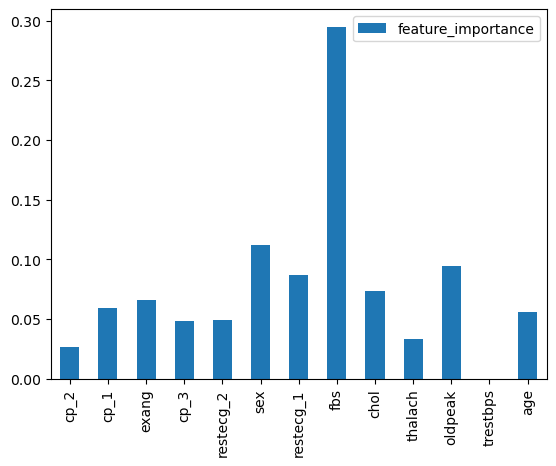

In [9]:
pd.DataFrame(
    pipeline["classifier"].feature_importances_,
    index=features,
    columns=["feature_importance"],
).plot(kind="bar")

In [10]:
# fmt:off
pipeline = Pipeline( [("preprocessor", preprocessor), ("classifier", XGBClassifier(eval_metric=f1_score))])
# fmt:on

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80        48
           1       0.08      0.06      0.07        16
           2       0.30      0.27      0.29        11
           3       0.27      0.27      0.27        11
           4       0.00      0.00      0.00         4

    accuracy                           0.53        90
   macro avg       0.28      0.29      0.29        90
weighted avg       0.49      0.53      0.51        90



In [11]:
# fmt:off
pipeline = Pipeline( [("preprocessor", preprocessor), ("classifier", XGBClassifier(eval_metric=f1_score))])
# fmt:on

sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79        48
           1       0.13      0.12      0.13        16
           2       0.25      0.27      0.26        11
           3       0.29      0.18      0.22        11
           4       0.00      0.00      0.00         4

    accuracy                           0.52        90
   macro avg       0.28      0.28      0.28        90
weighted avg       0.49      0.52      0.50        90



<Axes: >

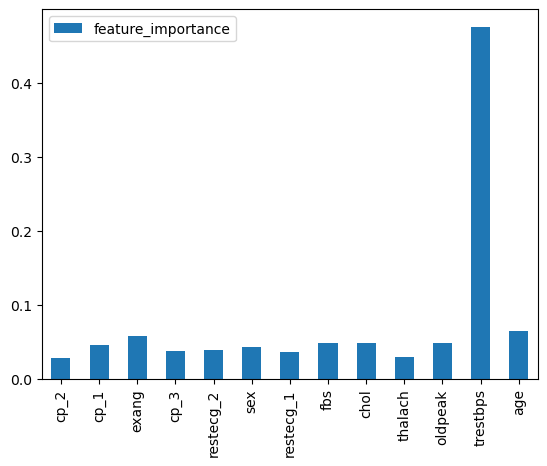

In [12]:
pd.DataFrame(
    pipeline["classifier"].feature_importances_,
    index=features,
    columns=["feature_importance"],
).plot(kind="bar")

In [13]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Generate sample data (replace with your dataset loading)
np.random.seed(0)
num_samples = 1000
num_features = 10
num_numeric_features = 5
data = np.random.rand(num_samples, num_features)
binary_data = np.random.choice(
    [0, 1], size=(num_samples, num_features - num_numeric_features)
)
X = np.concatenate((data[:, :num_numeric_features], binary_data), axis=1)
y = np.random.choice([0, 1], size=num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the preprocessor for numeric and binary features
numeric_features = list(range(num_numeric_features))
binary_features = list(range(num_numeric_features, num_features))

preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), numeric_features),
        (
            "cat",
            OneHotEncoder(),
            binary_features,
        ),  # Assuming binary features are categorical
    ]
)

# Create pipelines for each classifier
pipelines = []

# XGBoost Classifier
xgb_pipeline = Pipeline(
    [("preprocessor", preprocessor), ("classifier", XGBClassifier())]
)
pipelines.append(("XGBoost", xgb_pipeline))

# Support Vector Classifier (SVC)
svc_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", SVC())])
pipelines.append(("SVC", svc_pipeline))

# Neural Network (Multi-layer Perceptron)
mlp_pipeline = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                transformers=[
                    ("num", StandardScaler(), numeric_features),
                    ("cat", OneHotEncoder(), binary_features),
                ]
            ),
        ),
        ("classifier", MLPClassifier()),
    ]
)
pipelines.append(("Neural Network", mlp_pipeline))

# Compare the performance of the classifiers
results = []
for name, pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append((name, accuracy))

# Print the results
for name, accuracy in results:
    print(f"{name} Accuracy: {accuracy:.2f}")

XGBoost Accuracy: 0.54
SVC Accuracy: 0.54
Neural Network Accuracy: 0.49


c:\Users\joanp\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
